<a href="https://colab.research.google.com/github/sketcher03/learning_app_v1/blob/main/Image_Segmentation_499.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless

In [ ]:
from google.colab.patches import cv2_imshow # Import the cv2_imshow function

In [ ]:
import cv2
import numpy as np
import os

In [ ]:
image = cv2.imread("image.png")

if image is None:
    print("Error: Could not load image.")

Error: Could not load image.


## Image Preprocessing

In [ ]:
def preprocess_image(image):
    """Preprocess image: Convert to grayscale, enhance contrast, apply adaptive thresholding."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_gray = gray.copy()  # Keep a copy of the original grayscale image

    # Increase contrast (useful for handwritten text)
    # CLAHE contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5,5), 0)

    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # OTSU's thresholding as a fallback
    _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary = cv2.bitwise_and(binary, otsu_thresh)  # Combine both
    # binary = otsu_thresh

    '''
    # Increase dilation to make words "bleed" more
    dilation_kernel = np.ones((5, 5), np.uint8)
    # binary = cv2.dilate(binary, dilation_kernel)
    '''

    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    '''
    # Apply morphological closing to connect letters into full words
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))  # Wider horizontal kernel
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, horizontal_kernel, iterations=2)
    '''

    # Show the preprocessed binary image
    print("Preprocessed Image")
    cv2_imshow(binary)
    cv2.waitKey(0)

    return binary, original_gray

## Answer Boxes Detection

In [ ]:
def find_answer_boxes(binary_image, original_image):
    """Finds contours representing the answer boxes and visualizes them."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area_ratio = 0.5  # Adjust as needed

    filtered_contours = [
        ctr for ctr in contours
        if (cv2.contourArea(ctr) / (cv2.boundingRect(ctr)[2] * cv2.boundingRect(ctr)[3])) > min_area_ratio
    ]

    # Filter contours by area (assumed answer box size)
    min_area = 10000
    max_area = 100000
    filtered_contours = [ctr for ctr in filtered_contours if min_area < cv2.contourArea(ctr) < max_area]

    ''' Debugging

    for i in range(20):  # Check top 5
        x, y, w, h = cv2.boundingRect(filtered_contours[i])
        print(f"Contour {i} - Bounding Box: x={x}, y={y}, w={w}, h={h}, Area={w*h}")
        print(f"Contour {i} - Area: {cv2.contourArea(filtered_contours[i])}")
        print(f"Contour {i} - Area Ratio: {cv2.contourArea(filtered_contours[i]) / (w*h)}")

    Debugging '''

    # Sort boxes top-to-bottom, then left-to-right
    # filtered_contours = sorted(filtered_contours, key=lambda ctr: (cv2.boundingRect(ctr)[1], cv2.boundingRect(ctr)[0]))
    filtered_contours = sorted(filtered_contours, key=lambda ctr: (cv2.boundingRect(ctr)[1] // 50, cv2.boundingRect(ctr)[0]))

    print(f"Detected {len(filtered_contours)} answer boxes.")

    # Draw detected answer boxes
    boxes_image = original_image.copy()
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        # print(f"Box area: {cv2.contourArea(contour)}")
        cv2.rectangle(boxes_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Show the detected answer boxes
    print("Detected Answer Boxes")
    cv2_imshow(boxes_image)
    cv2.waitKey(0)

    return filtered_contours

## Word Extraction

In [ ]:
def extract_word_from_box(box, original_gray, index, x_offset, y_offset):
    """Extracts entire words from the box using Connected Component Analysis and displays them."""
    # Apply dilation to merge letters
    kernel = np.ones((10, 10), np.uint8)
    dilated = cv2.dilate(box, kernel, iterations=3)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated, connectivity=8)

    words = []
    for i in range(1, num_labels):  # Ignore background label (0)
        x, y, w, h, area = stats[i]

        # Filter out noise but allow smaller words
        if 10000 < area < 20000:  # Reduced lower threshold to avoid missing words
            # Crop from the **original grayscale image** using the adjusted coordinates
            word = original_gray[y_offset + y: y_offset + y + h, x_offset + x: x_offset + x + w]
            words.append(word)

    # Show the segmented words from this box

    '''
    for i, word in enumerate(words):
        print(f"Box {index} - Word {i+1}")
        cv2_imshow(word)
        cv2.waitKey(0)
    '''

    return words

In [ ]:
def save_debug_images(image, name, folder="detected_boxes"):
    """Saves images at different stages for debugging."""
    if not os.path.exists(folder):
        os.makedirs(folder)

    path = os.path.join(folder, name)
    cv2.imwrite(path, image)

Preprocessed Image


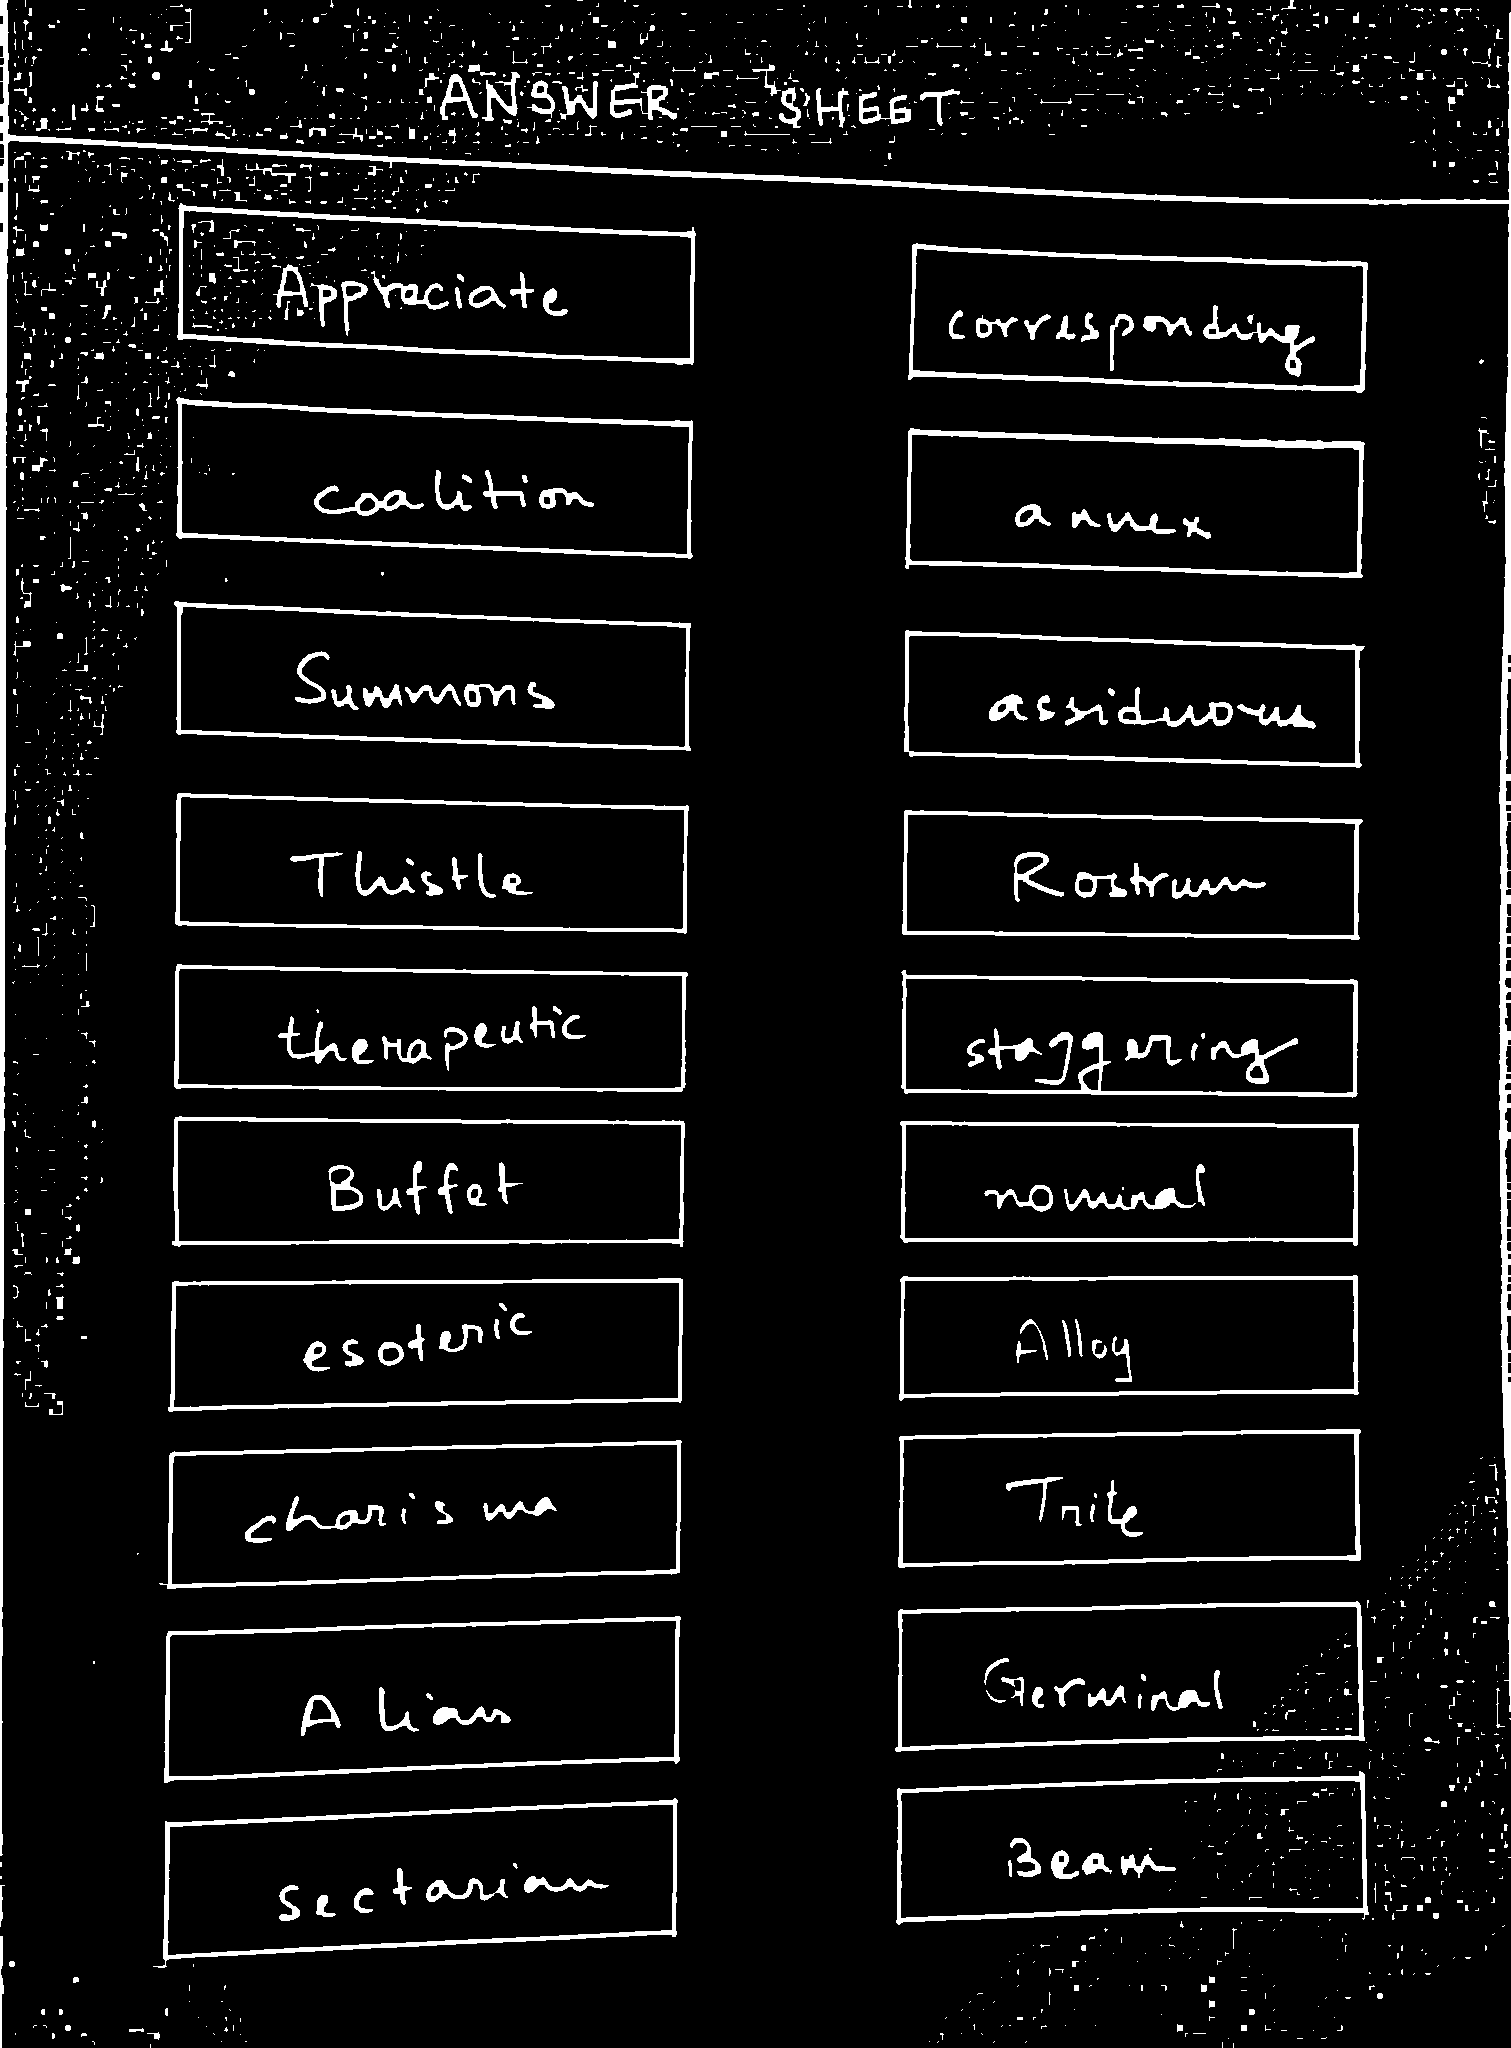

Detected 20 answer boxes.
Detected Answer Boxes


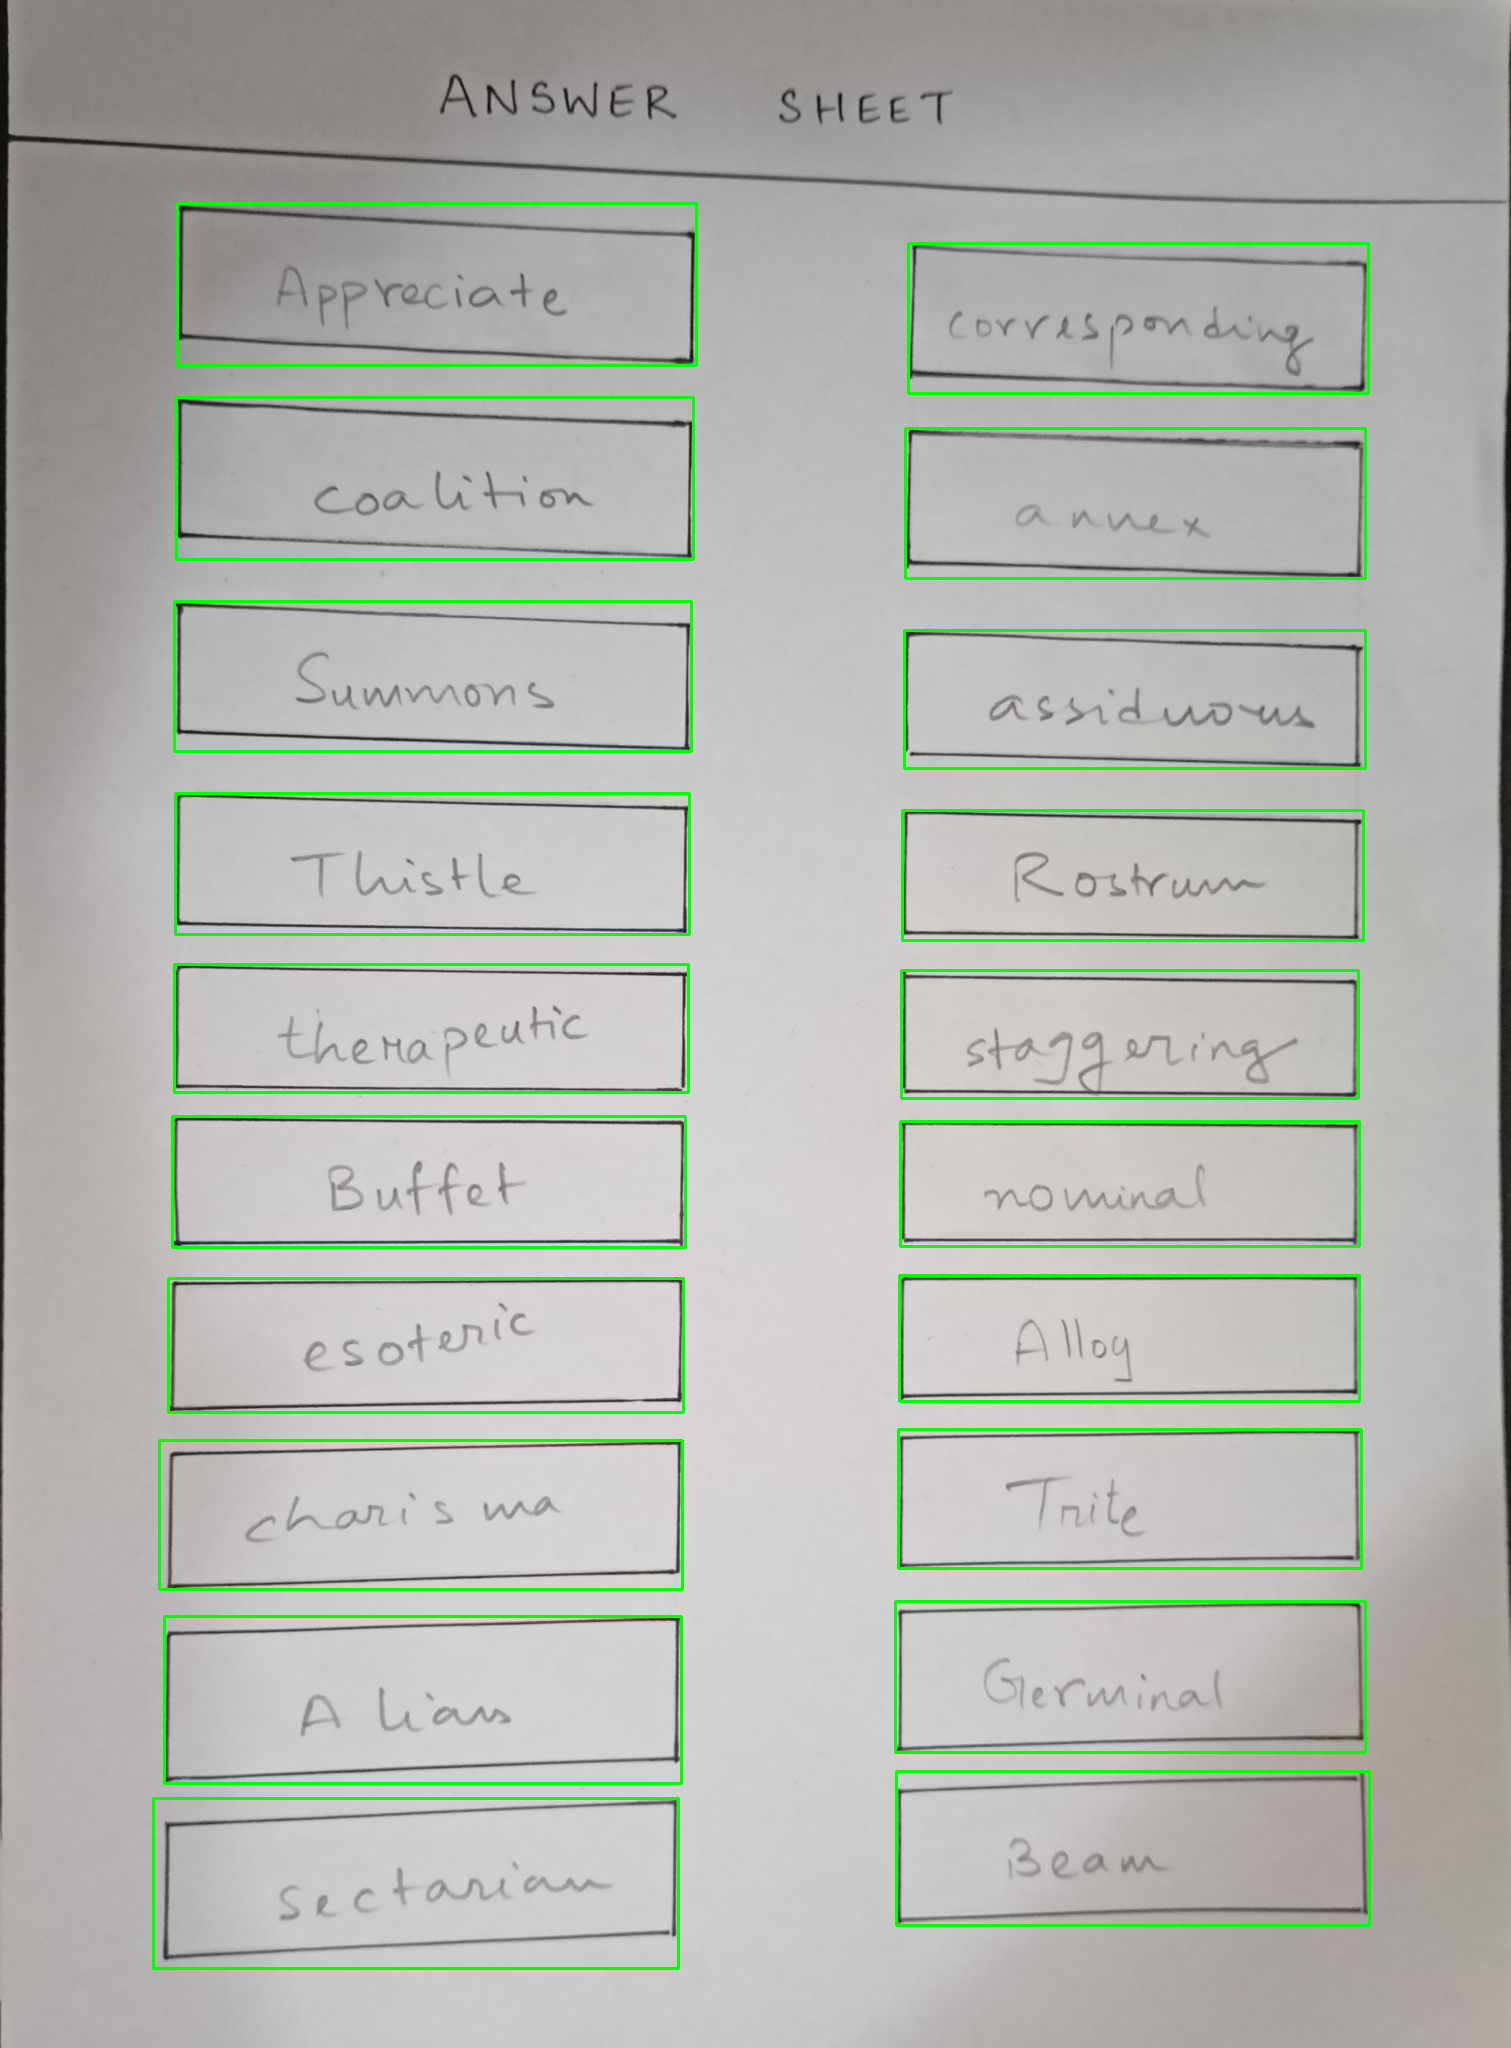

Extracted Word 1


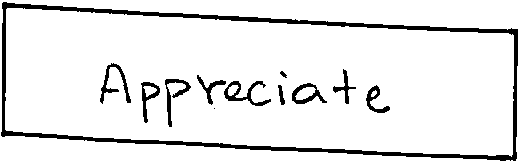

Extracted Word 2


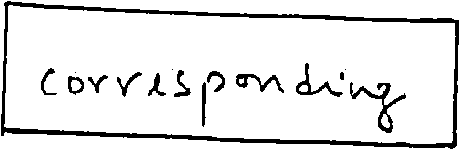

Extracted Word 3


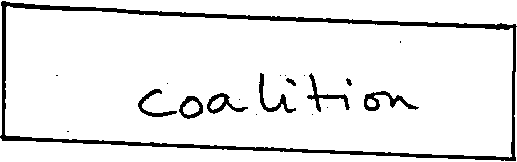

Extracted Word 4


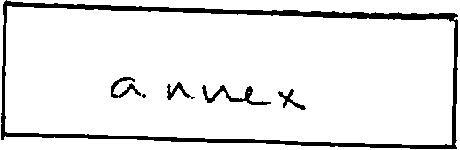

Extracted Word 5


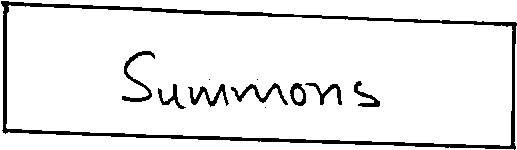

Extracted Word 6


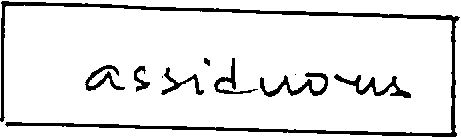

Extracted Word 7


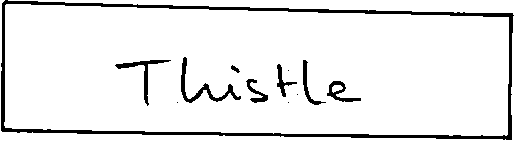

Extracted Word 8


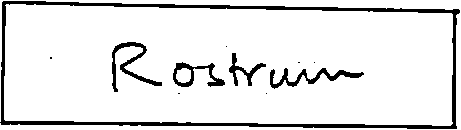

Extracted Word 9


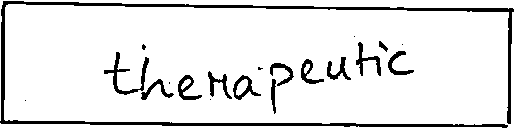

Extracted Word 10


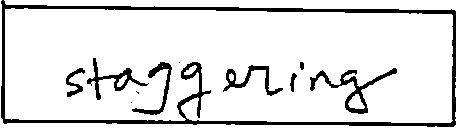

Extracted Word 11


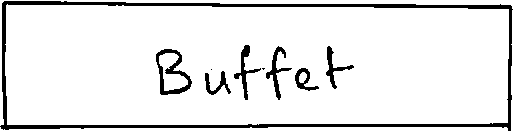

Extracted Word 12


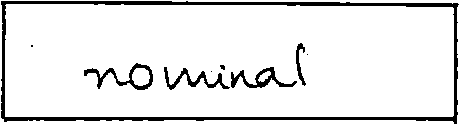

Extracted Word 13


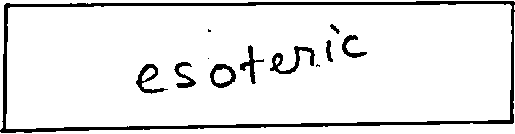

Extracted Word 14


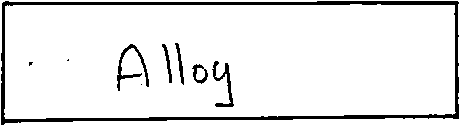

Extracted Word 15


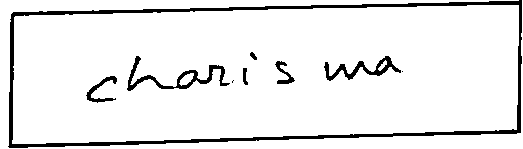

Extracted Word 16


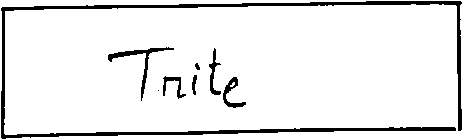

Extracted Word 17


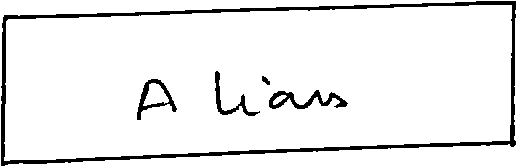

Extracted Word 18


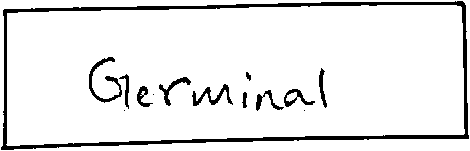

Extracted Word 19


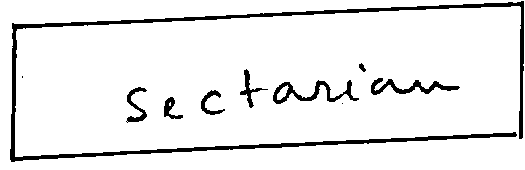

Extracted Word 20


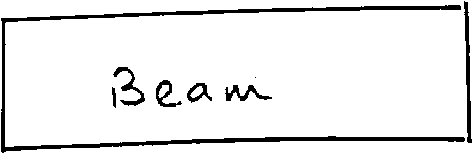

In [ ]:
# Load the image
image = cv2.imread("answers.jpg")
if image is None:
    print("Error: Could not load image.")

# Preprocess the image (returns both binarized & grayscale versions)
binary_image, original_gray = preprocess_image(image)

# Save preprocessed image
save_debug_images(binary_image, "preprocessed_binary.png")

# Find answer boxes
contours = find_answer_boxes(binary_image, image)

all_words = []
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    cropped_box = original_gray[y:y+h, x:x+w]

    cropped_box_thresh = cv2.adaptiveThreshold(cropped_box, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 7)

    # Save individual box images
    save_debug_images(cropped_box_thresh, f"box_{i+1}.png")

    all_words.append(cropped_box_thresh)

if not all_words:
    print("No words detected. Check the preprocessing parameters.")

# Save words for debugging
save_debug_images(binary_image, "final_segmented_words.png")

# Display all extracted words
for i, word in enumerate(all_words):
    print(f"Extracted Word {i+1}")
    cv2_imshow(word)
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:
def save_images(image, name, folder="cleaned_images"):
    """Saves images at different stages for debugging."""
    if not os.path.exists(folder):
        os.makedirs(folder)

    path = os.path.join(folder, name)
    cv2.imwrite(path, image)

## Preprocessing for OCR

In [ ]:
def remove_box_border(img):

    # Threshold
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations to detect horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detect_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # --- Remove Vertical Lines ---
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    detect_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # Combine detected lines
    detected_lines = cv2.add(detect_horizontal, detect_vertical)

    # Subtract lines from the binary image
    cleaned = cv2.subtract(binary, detected_lines)

    # --- Step 3: Erode the Image to Remove Tiny Residuals ---
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.erode(cleaned, kernel, iterations=1)

    # --- Step 4: DILATE to make handwriting stronger ---
    dilation_kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.dilate(cleaned, dilation_kernel, iterations=1)

    # --- Step 4: Remove Small Contours ---
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.ones(cleaned.shape[:2], dtype="uint8") * 255  # Start with white mask

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 10:  # <- Increased minimum area
            cv2.drawContours(mask, [contour], -1, 0, -1)

    # Apply the mask
    result = cv2.bitwise_and(cleaned, cleaned, mask=mask)

    #detect_horizontal_2 = cv2.morphologyEx(result, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # Invert back to normal
    cleaned = cv2.bitwise_not(result)

    return cleaned


## Extract Handwriting Only

In [ ]:
def crop_handwriting_only(img):

    # Threshold
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours of handwriting
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    handwriting_contours = [c for c in contours if cv2.contourArea(c) > 100]  # Ignore tiny noise

    if len(handwriting_contours) == 0:
        print("No handwriting detected!")
        return None

    # Find bounding box covering all handwriting
    all_points = np.vstack(handwriting_contours)
    x, y, w, h = cv2.boundingRect(all_points)

    # Crop the image
    cropped = img[y:y+h, x:x+w]

    return cropped

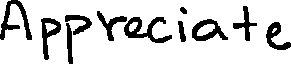

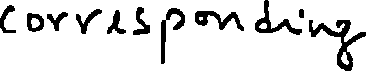

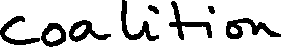

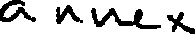

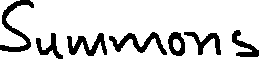

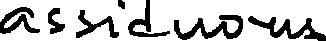

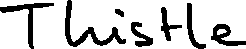

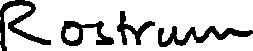

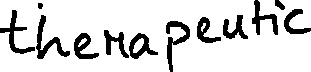

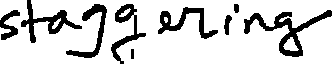

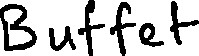

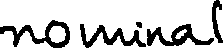

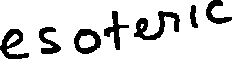

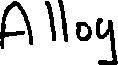

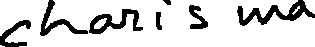

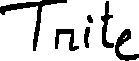

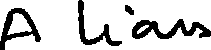

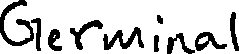

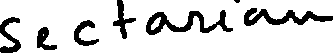

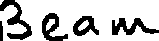

In [ ]:
cropped_words = []
for i, image in enumerate(all_words):
    cleaned = remove_box_border(image)

    cropped = crop_handwriting_only(cleaned)

    cv2_imshow(cropped)
    cv2.waitKey(0)

    cropped_words.append(cropped)

    save_images(cropped, f"cleaned_box_{i+1}.png")

In [ ]:
!pip install transformers torch torchvision torchaudio sentencepiece Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## TrOCR Integration

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Load the TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
for i, image_np in enumerate(cropped_words):

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image_np)

    image = image.convert("RGB")

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    # Perform OCR
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    print(f"Predicted Text {i+1}:", generated_text)

Predicted Text 1: Appreciate
Predicted Text 2: corves providing
Predicted Text 3: coalition
Predicted Text 4: a nnex
Predicted Text 5: Summons
Predicted Text 6: as siduous
Predicted Text 7: Thistle
Predicted Text 8: Rostrum
Predicted Text 9: therapeutic
Predicted Text 10: staggering .
Predicted Text 11: Buffet
Predicted Text 12: no mind
Predicted Text 13: es atomic
Predicted Text 14: A alloy
Predicted Text 15: charis wa
Predicted Text 16: Trite
Predicted Text 17: A Lions
Predicted Text 18: Germinal
Predicted Text 19: secarian
Predicted Text 20: be a m .
